# Facial Age Detection using Computer Vision

## Introduction
The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. 
Their shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
We will use computer vision methods to determine the age of a person from a photo by training a model using a set of photographs of people with their ages indicated. 

**Data Description:**
- folder with 7.6k photos
    - `/datasets/faces/final_files/`
- file with labels
    - `/datasets/faces/labels.csv`
        - `file_name` - name of the file in the corresponding folder with photos
        - `real_age` - actual age of the person in the photo

**Plan:**
- Load the photos with labels
- Exploratory Data Analysis
- Train and evaluate the model (on the GPU platform)
- Make conclusions of the model evaluation

## Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
datagen = ImageDataGenerator(rescale=1./ 255)
datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=12345)
datagen_flow

Found 7591 validated image filenames.


## EDA

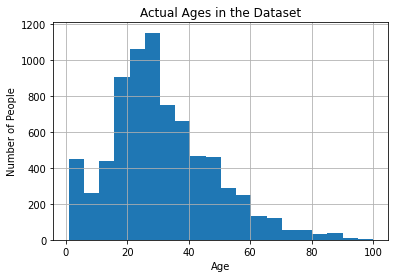

In [14]:
labels.hist(bins=20)
plt.title('Actual Ages in the Dataset')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.show()

- Median age is 29 years old
- The range of ages is 1 to 100 years old
- The age distribution of all images is positively skewed, there are relatively few images of older people and more images of younger people

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Missing values
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

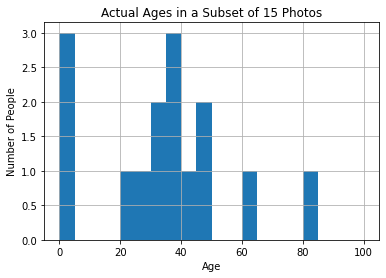

In [17]:
# take a subsample of the dataset and plot age distribution for reference
images_sample = labels.sample(15)
images_sample.hist(bins=20, range=(0, 100))
plt.title('Actual Ages in a Subset of 15 Photos')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.show()

The small subset of photos includes a wide range of ages so we can get an overall impression of the data. 

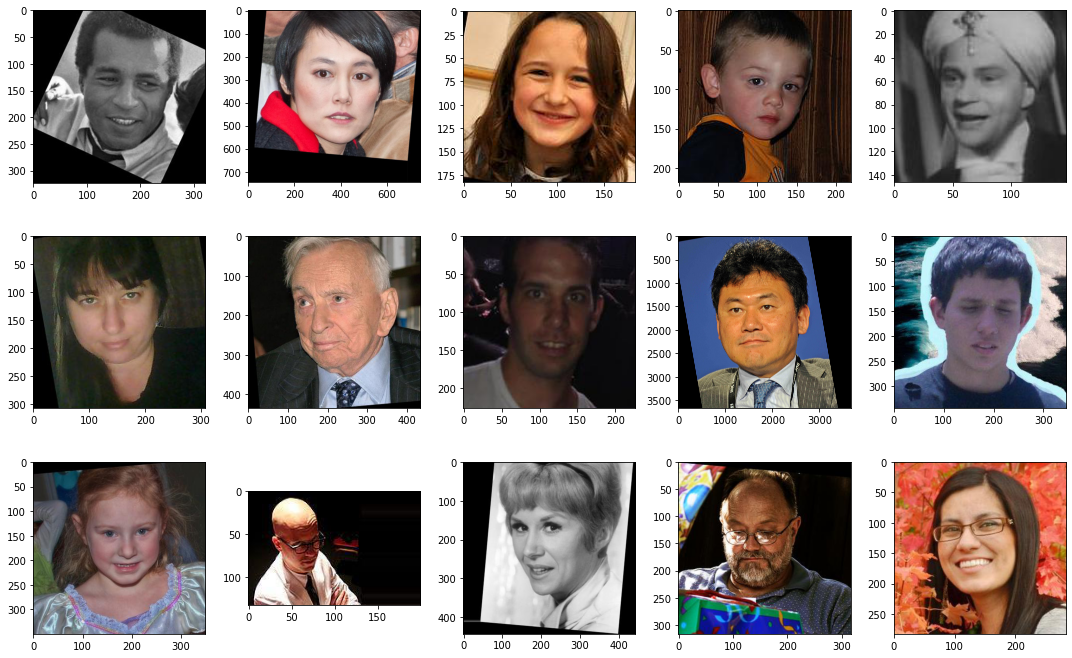

In [18]:
# print subset of images for different ages
rows = 3
cols = 5
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

for row in range(rows):
    for col in range(cols):
        image = Image.open('/datasets/faces/final_files/'+ str(images_sample['file_name'].iloc[img_count]))
        array = np.array(image)
        axes[row, col].imshow(array)
        img_count+=1
        fig.tight_layout()

### Findings

- There are 7591 images
- Median age is 29 years old
- The range of ages is 1 to 100 years old
- The mean is higher than the median so the data is positively skewed
- There are no missing values in the labeled dataset
- During training, we can augment the images using rotation, reflection, zoom and shift which should ensure that the integrity of original images remains the same

## Modeling

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       rotation_range=20,
                                       zoom_range=0.2)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           batch_size=32,
                                           class_mode='raw',
                                           subset='training',
                                           seed=12345)
    return train_gen_flow

In [11]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           batch_size=32, 
                                           class_mode='raw', 
                                           subset='validation',
                                           seed=12345)

    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(
        optimizer=optimizer, 
        loss='mse', 
        metrics=['mae'])
    
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
        callbacks=callbacks
    )

    return model

### Prepare the Script to Run on the GPU Platform

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

```python 

Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-09-14 14:14:20.639183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-14 14:14:21.168246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 117s - loss: 231.7203 - mae: 11.4302 - val_loss: 323.6194 - val_mae: 13.3213
Epoch 2/20
178/178 - 110s - loss: 150.0487 - mae: 9.3533 - val_loss: 335.2678 - val_mae: 13.5825
Epoch 3/20
178/178 - 110s - loss: 133.0010 - mae: 8.8205 - val_loss: 289.7262 - val_mae: 12.8989
Epoch 4/20
178/178 - 110s - loss: 122.8566 - mae: 8.3881 - val_loss: 200.3394 - val_mae: 10.8395
Epoch 5/20
178/178 - 111s - loss: 110.3747 - mae: 7.9976 - val_loss: 150.4778 - val_mae: 9.4110
Epoch 6/20
178/178 - 110s - loss: 104.7794 - mae: 7.7790 - val_loss: 121.7909 - val_mae: 8.4337
Epoch 7/20
178/178 - 110s - loss: 103.1841 - mae: 7.6358 - val_loss: 140.3877 - val_mae: 9.2054
Epoch 8/20
178/178 - 110s - loss: 92.5553 - mae: 7.2906 - val_loss: 180.0503 - val_mae: 9.8085
Epoch 9/20
178/178 - 110s - loss: 88.0791 - mae: 7.1404 - val_loss: 93.7230 - val_mae: 7.3370
Epoch 10/20
178/178 - 110s - loss: 87.8620 - mae: 7.1106 - val_loss: 233.4792 - val_mae: 11.5074
Epoch 11/20
178/178 - 110s - loss: 83.4740 - mae: 6.9210 - val_loss: 141.6738 - val_mae: 8.8752
Epoch 12/20
178/178 - 110s - loss: 80.4631 - mae: 6.8318 - val_loss: 84.0858 - val_mae: 7.1326
Epoch 13/20
178/178 - 110s - loss: 76.0180 - mae: 6.6123 - val_loss: 143.7589 - val_mae: 8.8497
Epoch 14/20
178/178 - 110s - loss: 74.6839 - mae: 6.5508 - val_loss: 82.5158 - val_mae: 6.8477
Epoch 15/20
178/178 - 110s - loss: 72.5260 - mae: 6.4356 - val_loss: 90.0348 - val_mae: 7.0882
Epoch 16/20
178/178 - 110s - loss: 71.1450 - mae: 6.4151 - val_loss: 98.1727 - val_mae: 7.5789
Epoch 17/20
178/178 - 110s - loss: 74.6135 - mae: 6.5644 - val_loss: 113.1908 - val_mae: 7.5903
Epoch 18/20
178/178 - 110s - loss: 70.3372 - mae: 6.4174 - val_loss: 86.2705 - val_mae: 7.1763
Epoch 19/20

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
178/178 - 110s - loss: 67.4951 - mae: 6.2628 - val_loss: 88.1437 - val_mae: 7.2869
Epoch 20/20
178/178 - 110s - loss: 52.6862 - mae: 5.5232 - val_loss: 66.6974 - val_mae: 6.0891
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 66.6974 - mae: 6.0891
Test MAE: 6.0891

```

## Conclusions

- The model has a mean absolute error on the test set of 6.09, so there is a +/- 6 year difference between the actual and predicted values on average.
- This model might not be the best solution to help the customer ensure they do not sell alcohol to people underage since the error for this model is relatively large.
  
**Model Improvements:**
- The model could be improved by increasing the amount of training data. We should also make sure that the data is diverse and representative so it captures complexities of real-world data.
- Try other computer vision models and continue to tune the hyperparameters of this model and compare the results.
- Additional augmentations
- Introduce additional layers with normalization methods
- Try other optimizers (e.g., AdamW)
